
--- 問題2：開始訓練混合損失模型 ---
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - deriv_loss: 2.0546 - func_loss: 0.1311 - total_loss: 0.1516 - val_deriv_loss: 1.1793 - val_func_loss: 0.0361 - val_total_loss: 0.0479
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - deriv_loss: 1.2815 - func_loss: 0.0332 - total_loss: 0.0460 - val_deriv_loss: 0.2056 - val_func_loss: 0.0032 - val_total_loss: 0.0053
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - deriv_loss: 0.1392 - func_loss: 0.0024 - total_loss: 0.0038 - val_deriv_loss: 0.0622 - val_func_loss: 8.9005e-04 - val_total_loss: 0.0015
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - deriv_loss: 0.0585 - func_loss: 6.6982e-04 - total_loss: 0.0013 - val_deriv_loss: 0.0461 - val_func_loss: 3.9280e-04 - val_total_loss: 8.5408e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - deriv_loss: 0.0353 - func_loss: 3.5760e-04 - total_loss: 7.1067e-04 - val_deriv_loss: 0.0353 - val_func_loss: 2.1526e-04 - val_total_loss: 5.6845e-04
Epoch 6/

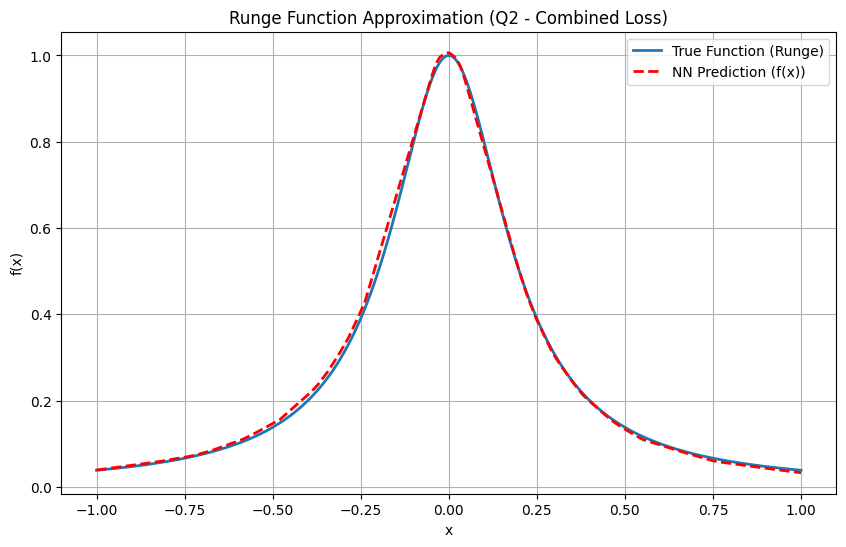

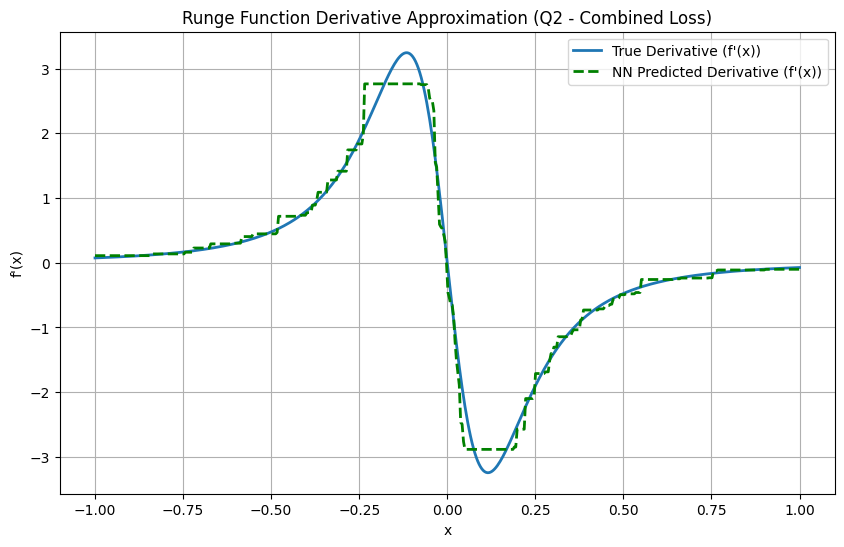

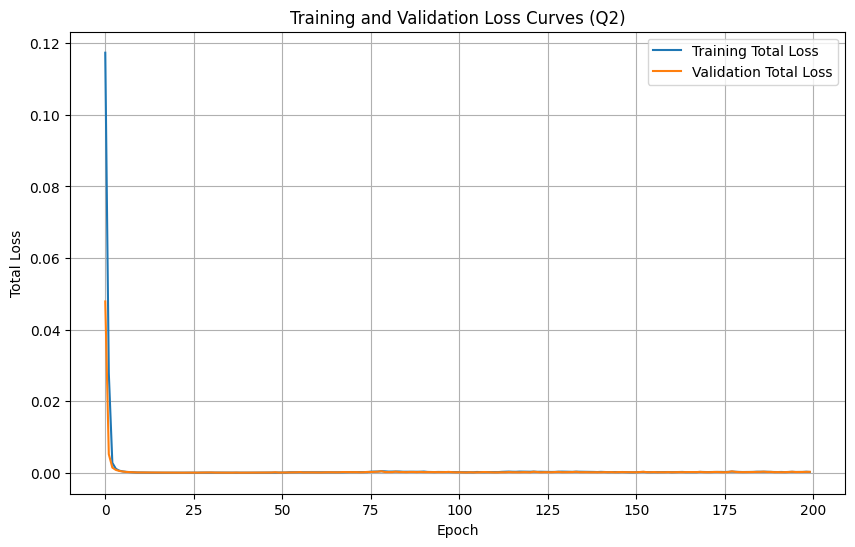


--- 錯誤報告 (Q2 - 混合損失模型) ---
函數 f(x) - Mean Squared Error (MSE): 0.00010350
函數 f(x) - Maximum Error: 0.03658646
導數 f'(x) - Mean Squared Error (MSE): 0.02664991
導數 f'(x) - Maximum Error: 0.69669974


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def runge_function(x):
    return 1 / (1 + 25 * x**2)

def runge_derivative(x):
    return (-50 * x) / ((1 + 25 * x**2)**2)

N_train = 1000
X_train = np.random.uniform(-1, 1, N_train).reshape(-1, 1).astype(np.float32)
y_train = runge_function(X_train)

N_val = 200
X_val = np.random.uniform(-1, 1, N_val).reshape(-1, 1).astype(np.float32)
y_val = runge_function(X_val)

X_test = np.linspace(-1, 1, 500).reshape(-1, 1).astype(np.float32)
y_test_true = runge_function(X_test)
y_test_true_deriv = runge_derivative(X_test)

class PhysicsInformedModel(keras.Model):
    def __init__(self, base_model, lambda_deriv=0.01):
        super().__init__()
        self.base_model = base_model
        self.lambda_deriv = lambda_deriv
        self.mse_loss = keras.losses.MeanSquaredError()

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.func_loss_tracker = keras.metrics.Mean(name="func_loss")
        self.deriv_loss_tracker = keras.metrics.Mean(name="deriv_loss")

    def call(self, inputs):
        return self.base_model(inputs)

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.func_loss_tracker, self.deriv_loss_tracker]

    def train_step(self, data):
        x, y_true = data
        y_deriv_true = runge_derivative(x)

        with tf.GradientTape() as tape:

            with tf.GradientTape() as tape_inner:
                tape_inner.watch(x)

                y_pred = self.base_model(x, training=True)

            y_deriv_pred = tape_inner.gradient(y_pred, x)
            if y_deriv_pred is None:
                y_deriv_pred = tf.zeros_like(y_deriv_true)


            loss_f = self.mse_loss(y_true, y_pred)
            loss_d = self.mse_loss(y_deriv_true, y_deriv_pred)

            total_loss = loss_f + self.lambda_deriv * loss_d

        grads = tape.gradient(total_loss, self.base_model.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.base_model.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.func_loss_tracker.update_state(loss_f)
        self.deriv_loss_tracker.update_state(loss_d)


        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """
        覆寫 Keras 的 `test_step` 方法，用於驗證。
        """
        x, y_true = data
        y_deriv_true = runge_derivative(x)


        with tf.GradientTape() as tape_inner:
            tape_inner.watch(x)

            y_pred = self.base_model(x, training=False)

        y_deriv_pred = tape_inner.gradient(y_pred, x)

        if y_deriv_pred is None:
            y_deriv_pred = tf.zeros_like(y_deriv_true)

        loss_f = self.mse_loss(y_true, y_pred)
        loss_d = self.mse_loss(y_deriv_true, y_deriv_pred)

        total_loss = loss_f + self.lambda_deriv * loss_d

        self.total_loss_tracker.update_state(total_loss)
        self.func_loss_tracker.update_state(loss_f)
        self.deriv_loss_tracker.update_state(loss_d)

        return {m.name: m.result() for m in self.metrics}

base_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(1,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])
pinn_model = PhysicsInformedModel(base_model, lambda_deriv=0.01)

pinn_model.compile(optimizer=keras.optimizers.Adam())

print("\n--- 問題2：開始訓練混合損失模型 ---")
history = pinn_model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)
print("模型訓練完成！")

y_pred_nn = pinn_model.predict(X_test)


X_test_tf = tf.constant(X_test, dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(X_test_tf)
    y_pred = pinn_model(X_test_tf)

dy_dx_pred = tape.gradient(y_pred, X_test_tf).numpy()

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_test_true, label='True Function (Runge)', linewidth=2)
plt.plot(X_test, y_pred_nn, label='NN Prediction (f(x))', linestyle='--', linewidth=2, color='red')
plt.title('Runge Function Approximation (Q2 - Combined Loss)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_test_true_deriv, label="True Derivative (f'(x))", linewidth=2)
plt.plot(X_test, dy_dx_pred, label="NN Predicted Derivative (f'(x))", linestyle='--', linewidth=2, color='green')
plt.title('Runge Function Derivative Approximation (Q2 - Combined Loss)')
plt.xlabel('x')
plt.ylabel("f'(x)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(history.history['total_loss'], label='Training Total Loss')
plt.plot(history.history['val_total_loss'], label='Validation Total Loss')
plt.title('Training and Validation Loss Curves (Q2)')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- 錯誤報告 (Q2 - 混合損失模型) ---")
func_mse = np.mean((y_test_true - y_pred_nn)**2)
func_max_error = np.max(np.abs(y_test_true - y_pred_nn))
deriv_mse = np.mean((y_test_true_deriv - dy_dx_pred)**2)
deriv_max_error = np.max(np.abs(y_test_true_deriv - dy_dx_pred))

print(f"函數 f(x) - Mean Squared Error (MSE): {func_mse:.8f}")
print(f"函數 f(x) - Maximum Error: {func_max_error:.8f}")
print(f"導數 f'(x) - Mean Squared Error (MSE): {deriv_mse:.8f}")
print(f"導數 f'(x) - Maximum Error: {deriv_max_error:.8f}")

